<h1 style="text-align: center;">Should You Run for a First Down?</h1>
<h3 style="text-align: center; font-style:italic;margin-top: 3px">Analyzing Play-by-Play NFL Data </h3>
<h4 style="text-align: center;">Alex Cohen - DATS 6202 </h4>

---

<img src='Football.jpg' style='border-radius:8px;width:90%;height:400px;' align='center'></img>

<h2 style='text-align: center' >Introduction</h2>

---
In football, teams are allowed to stay on offense by moving a cumulative 10 yards closer to the opponents end zone within a series of four attempts. However, if they do not move the ball 10 yards closer to the opponents end zone within the four attempts, they turn the ball over to the opposing team at the position where the ball currently is. The opposing team then gets to go on offense and try to score points. For this reason, being able to consistently move the ball those ten yards within four plays (called a 'first down') is incredibly important towards winning the game.

Football teams generally have two options on offense to try and move the ball those 10 yards for their team:
    
>throwing the ball through the air (passing play)<br /><br />
>handing the ball to a teammate that attempts to then run the ball forward (running play).
    


Teams are choosing to use more and more passing plays instead of running plays to gain yards and score points over the past few years due to rule changes (among other factors). Yet passing plays are risky because it provides the other team a chance to catch the ball (called an interception), at which point they get to go on offense. There is the chance that someone running the ball drops it (called a fumble), however this is less likely than an interception. Despite this, running has seemingly become an underappreciated part of the game - once which we want to explore further.

**The goal of this project will be to figure out the likelihood that a team can use a running play to get the remaining yards required for a first down and remain on offense for any given play**

---

<h2 style='text-align: center' >Conducting the experiment</h2>

___

### Part 1: Importing, cleaning, and exploring our data

In [1]:
# import our packages
import pandas as pd
import numpy as np
import re
import datetime as DT
import kaggle

In [2]:
# this assumes you have already downloaded the data, since we don't want to upload Kaggle data here
data = pd.read_csv('train.csv.zip', low_memory=False)

In [3]:
data.shape

(509762, 49)

So we have __509,762__ records to analyze. However, this data includes information about everyone on the field at a given time. Since most of the information will be the same, we want to reduce this down to one record per play

In [4]:
# Because the data had records of all 22 players on the field (11 on offense and 11 on defense),
# we need to find the total number of plays
print()
print('We have {} unique plays to analyze. Much better!'.format(data[data.NflId == data.NflIdRusher]['PlayId'].count()))
print()


We have 23171 unique plays to analyze. Much better!



In [5]:
# Getting a sample of this reduced data
data = data[data.NflId == data.NflIdRusher].reset_index()
data = data.drop(columns = 'index')
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000345,home,15.53,25.36,4.45,3.20,0.46,186.22,275.44,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000395,away,29.99,27.12,3.90,2.53,0.44,34.27,157.92,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


That's a lot of information. Let's check out the data we have available (from the Kaggle data dictionary), sorting them into a few different categories.

<span style='text-decoration:underline'> **Game Related Information** </span>

- **GameId** - a unique game identifier
- **Season** - year of the season
- **HomeTeamAbbr** - home team abbreviation
- **VisitorTeamAbbr** - visitor team abbreviation
- **Week** - week into the season
- **Stadium** - stadium where the game is being played
- **Location** - city where the game is being player
- **StadiumType** - description of the stadium environment
- **Turf** - description of the field surface
- **GameWeather** - description of the game weather
- **Temperature** - temperature (deg F)
- **Humidity** - humidity
- **WindSpeed** - wind speed in miles/hour
- **WindDirection** - wind direction

<span style='text-decoration:underline'> **Play Specific Information** </span>

- **PlayId** - a unique play identifier
- **Team** - home or away
- **YardLine** - the yard line of the line of scrimmage
- **Quarter** - game quarter (1-5, 5 == overtime)
- **GameClock** - time on the game clock
- **PossessionTeam** - team with possession
- **Down** - the down (1-4)
- **Distance** - yards needed for a first down
- **FieldPosition** - which side of the field the play is happening on
- **HomeScoreBeforePlay** - home team score before play started
- **VisitorScoreBeforePlay** - visitor team score before play started
- **OffenseFormation** - offense formation
- **OffensePersonnel** - offensive team positional grouping
- **DefendersInTheBox** - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- **DefensePersonnel** - defensive team positional grouping
- **PlayDirection** - direction the play is headed
- **TimeHandoff** - UTC time of the handoff
- **TimeSnap** - UTC time of the snap

<span style='text-decoration:underline'> **Player Related Information** </span>

- **NflId** - a unique identifier of the player
- **DisplayName** - player's name
- **JerseyNumber** - jersey number
- **NflIdRusher** - the NflId of the rushing player
- **X** - player position along the long axis of the field
- **Y** - player position along the short axis of the field
- **S** - speed in yards/second
- **A** - acceleration in yards/second^2
- **Dis** - distance traveled from prior time point, in yards
- **Orientation** - orientation of player (deg)
- **Dir** - angle of player motion (deg)
- **PlayerHeight** - player height (ft-in)
- **PlayerWeight** - player weight (lbs)
- **PlayerBirthDate** - birth date (mm/dd/yyyy)
- **PlayerCollegeName** - where the player attended college
- **Position** - the player's position (the specific role on the field that they typically play)

<span style='text-decoration:underline'> **What we are predicting** </span>
- **Distance** - yards needed for a first down
- **Yards** - the yardage gained on the play (you are predicting this)

Now that we have an idea about the data fields we're working with, let's start by understanding some of the values before doing some feature engineering

### Target Variable EDA
Let's find out a little more about our target variable - whether or not the team got a first down. This is comprised of two parts:
1. The number of yards needed for a first down (which is known before the play)
2. The number of yards gained on the play (which is NOT known before the play)

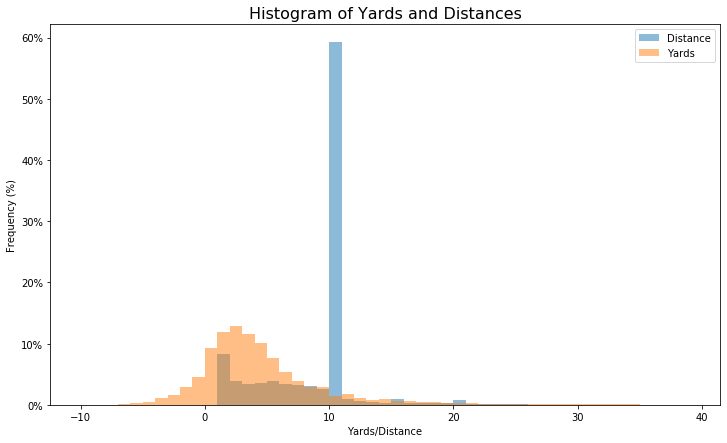

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# let's check the distribution of our target variables
plt.figure(figsize = (12,7))
plt.hist(data.Distance, bins = [i for i in range(40)], density = True, alpha = 0.5)
plt.hist(data.Yards, bins = [i for i in range(-10, 40)], density = True, alpha = 0.5)
plt.legend(['Distance', 'Yards'])
plt.title('Histogram of Yards and Distances', fontsize = 16)
plt.xlabel('Yards/Distance')
plt.ylabel('Frequency (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

As we can see - needing 10 yards is by far the most common value, as we would expect since every first down gives you 10 more yards to gain (ie. 'First and 10'). However it looks like the average play gains substantially fewer than 10 yards - let's see how often a play gains a first down

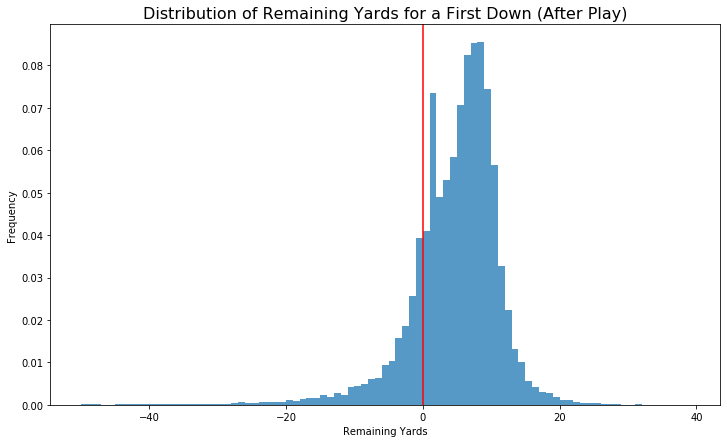

In [7]:
# let's check our transformed target variable
data['remaining_yards'] = data['Distance'] - data['Yards']
plt.figure(figsize = (12,7))
plt.hist(data['remaining_yards'], density = True, alpha = 0.75, bins = [i for i in range(-50, 40)])
plt.axvline(x = 0, color = 'red')
plt.title('Distribution of Remaining Yards for a First Down (After Play)', fontsize = 16)
plt.xlabel('Remaining Yards')
plt.ylabel('Frequency')
plt.show()

In [8]:
# let's find the true conversion rate in the data
data['first_down'] = np.where(data['remaining_yards'] <= 0, 1, 0)
data.drop(columns = ['remaining_yards', 'Yards'], inplace = True)
conversion_rate = round(data['first_down'].mean(), 4)
print()
print('The average first down conversion rate is {}%'.format(conversion_rate*100))


The average first down conversion rate is 21.15%


So only a little over 20% of plays gain enough yards for a first down - not great, but not too bad given you have up to four tries. This means that teams will gain a first down in 3 tries (to avoid punting on the fourth) ~50% of the time:

\\[P(fail_{all\ three \ attempts}) = (1-0.2115)^3 = (.7885)^3 = 49.02\%\\]

However, we know that not all plays are created equal - so lets take a look at some of the features we can use to help figure out when a first down is more likely

___

### EDA and Feature Engineering

#### Feature Engineering Part 1: Game Information

First, let's look at all the variables specific to an individual game

In [9]:
game_vars = ['GameId', 'Season', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 
             'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 
             'WindSpeed', 'WindDirection']

One thing we can immediately do is look at the home team, stadium, and location fields to see if there are any variables we can eliminate (as the same home team likely means the same stadium)

In [10]:
data.groupby(['HomeTeamAbbr', 'Stadium'])['Stadium'].count()

HomeTeamAbbr  Stadium                            
ARI           State Farm Stadium                     401
              University of Phoenix Stadium          346
ATL           Mercedes-Benz Dome                      39
              Mercedes-Benz Stadium                  654
BAL           M & T Bank Stadium                      49
              M&T Bank Stadium                       500
              M&T Stadium                            228
BUF           New Era Field                          782
CAR           Bank of America Stadium                638
CHI           Soldier Field                          697
CIN           Paul Brown Stadium                     702
              Paul Brown Stdium                       52
CLE           First Energy Stadium                    77
              FirstEnergy                            193
              FirstEnergy Stadium                    351
              FirstEnergyStadium                      53
              Twickenham Stadium      

In [11]:
data.groupby(['HomeTeamAbbr', 'Location'])['Location'].count()

HomeTeamAbbr  Location                 
ARI           Glendale, AZ                 747
ATL           Atlanta, GA                  693
BAL           Baltimore, Maryland           49
              Baltimore, Md.               728
BUF           Orchard Park NY              704
              Orchard Park, NY              78
CAR           Charlotte, NC                236
              Charlotte, North Carolina    402
CHI           Chicago, IL                  659
              Chicago. IL                   38
CIN           Cincinnati, OH                96
              Cincinnati, Ohio             658
CLE           Cleveland                     47
              Cleveland Ohio                53
              Cleveland, OH                 38
              Cleveland, Ohio              378
              Cleveland,Ohio               158
              London, England               50
DAL           Arlington, TX                 32
              Arlington, Texas             693
DEN           Denver

Since most of the interesting aspects of stadiums can be captured by a combination of the home team as well as the temperature/weather and field conditions, we will drop the location variable to avoid creating too many one-hot encoded features. 

The one thing that will be different is if the game is at a third party site (where neither team is really the 'home' team - which is most common when the NFL plays internationally. There are two main locations, England and Mexico City, where these games are played. We'll create an 'International' indicator variable to capture this information.

In [12]:
# create an international location flag and then drop location and stadium variables
data['International'] = np.where((data.Location.str.contains('London'))|(data.Location.str.contains('Mexico City')),
                                 1,
                                 0)
data.drop(columns = ['Location', 'Stadium'], inplace = True)
game_vars.remove('Location')
game_vars.remove('Stadium')

Since there are a lot of different field types and weather values (and some that seem to overlap between the two), we'll need to clean these fields as well

In [13]:
stadium_map = {'Outdoors':'Outdoor',
                'Indoors':'Indoor',
                'Retractable Roof': 'Indoor',
                'Open':'Outdoor',
                'Retr. Roof-Closed':'Indoor',
                'Retr. Roof - Closed': 'Indoor',
                'Outddors':'Outdoor',
                'Dome':'Indoor',
                'Domed, closed':'Indoor',
                'Indoor, Roof Closed': 'Indoor',
                'Retr. Roof Closed': 'Indoor',
                'Outdoor Retr Roof-Open': 'Open Dome',
                'Closed Dome': 'Indoor',
                'Oudoor':'Outdoor',
                'Ourdoor':'Outdoor',
                'Dome, closed': 'Indoor',
                'Retr. Roof-Open':'Open Dome',
                'Heinz Field':'Outdoor', # Heinz Field is an open field
                'Outdor':'Outdoor',
                'Retr. Roof - Open': 'Open Dome',
                'Domed, Open': 'Open Dome',
                'Domed, open':'Open Dome',
                'Cloudy':'Outdoor',
                'Bowl':'Indoor', 
                'Outside':'Outdoor',
                'Domed':'Indoor'}

In [14]:
weather_map = {'Clear and Warm':'Clear',
               'Sun & clouds':'Cloudy',
               'Sunny':'Clear',
               'Controlled Climate':'Controlled',
               'Mostly Sunny':'Clear',
               'Indoor':'Controlled',
               'Mostly Cloudy':'Cloudy',
               'Mostly Coudy':'Cloudy',
               'Partly sunny':'Clear',
               'Partly Cloudy':'Cloudy',
               'Cloudy':'Cloudy',
               'Sunny, highs to upper 80s':'Clear',
               'Indoors':'Controlled',
               'Light Rain':'Rainy',
               'Showers':'Rainy',
               'Partly cloudy':'Cloudy',
               'Partly Sunny':'Clear',
               '30% Chance of Rain':'Rainy',
               'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.':'Rainy',
               'Rain':'Rainy',
               'Cloudy, fog started developing in 2nd quarter':'Cloudy',
               'Coudy':'Cloudy',
               'Rain likely, temps in low 40s.':'Rainy',
               'Cold':'Cloudy',
               'N/A (Indoors)':'Controlled',
               'Clear skies':'Clear',
               'cloudy':'Cloudy',
               'Fair':'Clear',
               'Mostly cloudy':'Cloudy',
               'Cloudy, chance of rain':'Cloudy',
               'Heavy lake effect snow':'Snow',
               'Partly Cloudy':'Cloudy',
               'Cloudy, light snow accumulating 1-3"':'Snow',
               'Cloudy and cold':'Cloudy',
               'Snow':'Snow',
               'Hazy':'Cloudy',
               'Scattered Showers':'Rainy',
               'Cloudy and Cool':'Cloudy',
               'N/A Indoor':'Controlled',
               'Rain Chance 40%':'Rainy',
               'Clear and Sunny':'Clear',
               'Mostly Sunny':'Clear',
               'Sunny and warm':'Clear',
               'Partly clear':'Clear',
               'Cloudy, 50% change of rain':'Cloudy',
               'Clear and Sunny':'Clear',
               'Sunny, Windy':'Clear',
               'Clear and Cool':'Clear',
               'Sunny and clear':'Clear',
               'Mostly sunny skies':'Clear',
               'Partly Clouidy':'Cloudy',
               'Clear Skies':'Clear',
               'Sunny Skies':'Clear',
               'Overcast':'Cloudy',
               'T: 51; H: 55; W: NW 10 mph':'Clear',
               'Cloudy, Rain':'Rainy',
               'Rain shower':'Rainy',
               'Clear and cold':'Clear',
               'Rainy':'Rainy',
               'Sunny and cold':'Clear',
               'Mostly sunny':'Clear',
               'Clear and sunny':'Clear',
               'Clear and warm':'Clear',
               'Party Cloudy':'Cloudy',
               'Mostly Sunny Skies':'Clear'}

In [15]:
# applying our weather and stadium maps
data.StadiumType.replace(stadium_map, inplace = True)
data.GameWeather.replace(weather_map, inplace = True)

Additionally, there are a few games where the stadium type appears to be blank. Let's fill those in with the correct values (found through research)

In [16]:
data.loc[(data.HomeTeamAbbr == 'JAX') & (data.StadiumType.isna()),'StadiumType'] = 'Outdoor'
data.loc[(data.HomeTeamAbbr == 'LAC') & (data.StadiumType.isna()),'StadiumType'] = 'Outdoor'
data.loc[(data.HomeTeamAbbr == 'NYG') & (data.StadiumType.isna()),'StadiumType'] = 'Outdoor'

The Game Weather and Temperature data is blank for a lot of games played indoor - Game Weather will be set to 'Indoor' if the stadium is indoor, and the Temperature will be drawn from a random uniform distribution between 68 and 72 degrees (the best data I could find, but this could be improved in future work

In [17]:
data.GameWeather.value_counts()

Cloudy        9247
Clear         8538
Controlled    1795
Rainy         1393
Snow           214
Name: GameWeather, dtype: int64

In [18]:
data.loc[(data.StadiumType == 'Indoor') & (data.GameWeather.isna()), 'GameWeather'] = 'Controlled'
data.loc[(data.StadiumType == 'Indoor') & (data.Temperature.isna()), 'Temperature'] = round(np.random.uniform(68,72),0)
data.loc[data.GameWeather.isna(), 'GameWeather'] = 'Unknown'

Additionally, since there are a lot of kinds of turf, we want to simplify these down

In [19]:
# fix the field turf values
data['natural_field'] = np.where(data.Turf.str.lower().str.contains('|'.join(['grass', 'natural'])),
         1,
         0)
data.drop(columns = 'Turf', inplace=True)
game_vars.remove('Turf')

In [20]:
# Because all the stadiums are built facing different directions and teams change the direction they face every quarter,
# we will drop wind direction as a variable

data.drop(columns = 'WindDirection', inplace = True)
game_vars.remove('WindDirection')

In [21]:
# let's convert all of the windspeed values to integers by removing all of the non-numeric characters
data.WindSpeed = data.WindSpeed.apply(lambda x: (re.sub('[^0-9]', '', str(x))[:2])).replace('', 0).astype(int)

Finally, now that we have all of the game variables cleaned up, lets drop the gameID (since it doesn't really mean anything) and check out what our game variables look like

In [22]:
data.drop(columns = 'GameId', inplace = True)
game_vars.remove('GameId')
data[game_vars].head()

,Season,HomeTeamAbbr,VisitorTeamAbbr,Week,StadiumType,GameWeather,Temperature,Humidity,WindSpeed
0,2017,NE,KC,1,Outdoor,Clear,63.0,77.0,8
1,2017,NE,KC,1,Outdoor,Clear,63.0,77.0,8
2,2017,NE,KC,1,Outdoor,Clear,63.0,77.0,8
3,2017,NE,KC,1,Outdoor,Clear,63.0,77.0,8
4,2017,NE,KC,1,Outdoor,Clear,63.0,77.0,8


####  Feature Engineering Part 2: Play Information
Let's look at the variables related to the specific play 

In [23]:
play_vars = ['PlayId', 'Team', 'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition',
             'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox',
             'DefensePersonnel', 'PlayDirection', 'TimeHandoff','TimeSnap']

In [24]:
# first things first, we can drop the Team variable, since we know the home/away team from the Game Information
data.drop(columns = 'Team', inplace = True)
play_vars.remove('Team')

In [25]:
# we can convert the Yardline and FieldPosition variables into a 'yards to the endzone' variable to tell how close 
# the team is to scoring

data['yards_to_endzone'] = np.where(data.PossessionTeam == data.FieldPosition, 
                                    data.YardLine + 50, 
                                    data.YardLine)
data.drop(columns = ['FieldPosition', 'YardLine'], inplace = True)
play_vars.remove('FieldPosition')
play_vars.remove('YardLine')

In [26]:
# create a new variable denoting how long it takes from the time the ball is snapped to when it is handed to the runner
# (if it's longer - it might give the defense more time to get to the runner and decrease the yards gained)

data.TimeHandoff = data.TimeHandoff.apply(lambda x: re.sub('.000', '', x))
data.TimeHandoff = data.TimeHandoff.apply(lambda x: DT.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

data.TimeSnap = data.TimeSnap.apply(lambda x: re.sub('.000', '', x))
data.TimeSnap = data.TimeSnap.apply(lambda x: DT.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

def time_diff(x):
    return (x['TimeHandoff']-x['TimeSnap']).seconds

data['seconds_to_handoff'] = data.apply(time_diff, axis = 1)
play_vars.append('seconds_to_handoff')

In [27]:
# create an indicator variable for whether or not it is the home team that has possession
data['home_team_posession'] = np.where(data.HomeTeamAbbr == data.PossessionTeam, 
                                       1,
                                       0)
data.drop(columns = 'PossessionTeam', inplace=True)
play_vars.remove('PossessionTeam')

In [28]:
data[play_vars].head()

,PlayId,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,seconds_to_handoff
0,20170907000118,1,14:14:00,3,2,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,1
1,20170907000139,1,13:52:00,1,10,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:27,2017-09-08 00:44:26,1
2,20170907000189,1,13:02:00,1,10,0,0,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:45:17,2017-09-08 00:45:15,2
3,20170907000345,1,12:12:00,2,2,0,0,JUMBO,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",left,2017-09-08 00:48:41,2017-09-08 00:48:39,2
4,20170907000395,1,12:08:00,1,10,7,0,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08 00:53:14,2017-09-08 00:53:13,1


The two personnel columns may create a lot of different columns when one-hot encoded, so let's break them up into their different parts

In [29]:
# to make things easier, we can break up the offense and defense personnel columns into their respective parts, 
# so that we avoid creating too many one-hot encoded variables
def get_personnel(x, pos):
    regex = '\d '+ pos
    try:
        y = re.findall(regex, x)[0].split(' ')[0]
    except:
        y = 0
    return int(y)

In [30]:
# apply our function across the offense and defense positions
off_positions = ['RB', 'TE', 'WR', 'OL']
def_positions = ['DL', 'LB', 'DB']
for pos in off_positions:
    vec = data.OffensePersonnel.apply(lambda x: get_personnel(x, pos))
    data[pos] = vec

for pos in def_positions:
    vec = data.DefensePersonnel.apply(lambda x: get_personnel(x, pos))
    data[pos] = vec

play_vars.extend(off_positions)
play_vars.extend(def_positions)

# since most of the time the number of offensive linemen is 5 (and not specified) let's fill in this column with the 
# number of remaining personned (RB + TE + WR + 1, with the 1 being the QB)
data['OL'] = 11 - data.RB - data.TE - data.WR - 1

data.drop(columns = ['OffensePersonnel', 'DefensePersonnel'], inplace = True)
play_vars.remove('OffensePersonnel')
play_vars.remove('DefensePersonnel')

In [31]:
# finally, let's convert the clock to seconds so we don't need to worry about time formatting in our models
def convert_clock(x):
    return int(re.findall('[0-9]+',x)[0])*60 + int(re.findall('[0-9]+',x)[1])

data['seconds_in_quarter'] = data.GameClock.apply(lambda x: convert_clock(x))
data.drop(columns = 'GameClock', inplace = True)
play_vars.append('seconds_in_quarter')
play_vars.remove('GameClock')
data.Quarter = data.Quarter.astype(str)

In [32]:
# Finally, now that we have all our variables, let's drop the TimeHandoff field (We'll keep TimeSnap for later before 
# removing it)
data.drop(columns = 'TimeHandoff', inplace = True)
play_vars.remove('TimeHandoff')

Let's now examine the play variables

In [33]:
data[play_vars].head()

,PlayId,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,DefendersInTheBox,PlayDirection,TimeSnap,seconds_to_handoff,RB,TE,WR,OL,DL,LB,DB,seconds_in_quarter
0,20170907000118,1,3,2,0,0,SHOTGUN,6.0,left,2017-09-08 00:44:05,1,1,1,3,5,2,3,6,854
1,20170907000139,1,1,10,0,0,SHOTGUN,6.0,left,2017-09-08 00:44:26,1,1,1,3,5,2,3,6,832
2,20170907000189,1,1,10,0,0,SINGLEBACK,7.0,left,2017-09-08 00:45:15,2,1,1,3,5,2,3,6,782
3,20170907000345,1,2,2,0,0,JUMBO,9.0,left,2017-09-08 00:48:39,2,2,2,0,6,4,4,3,732
4,20170907000395,1,1,10,7,0,SHOTGUN,7.0,right,2017-09-08 00:53:13,1,1,3,1,5,3,2,6,728


#### Feature Engineering Part 3:  Player Variables

Finally - let's check out the variables related to the person actually running the ball

In [34]:
player_vars = ['NflId', 'DisplayName', 'JerseyNumber', 'NflIdRusher', 'X', 'Y', 'Orientation', 'Dir', 
               'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate', 'PlayerCollegeName', 'Position']

player_vars.append('TimeSnap')

In [35]:
data[player_vars].head()

,NflId,DisplayName,JerseyNumber,NflIdRusher,X,Y,Orientation,Dir,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,TimeSnap
0,2543773,James White,28,2543773,78.75,30.53,161.98,245.74,5-10,205,02/03/1992,Wisconsin,RB,2017-09-08 00:44:05
1,2543773,James White,28,2543773,71.07,27.16,210.70,312.20,5-10,205,02/03/1992,Wisconsin,RB,2017-09-08 00:44:26
2,2543773,James White,28,2543773,48.66,19.11,140.82,221.96,5-10,205,02/03/1992,Wisconsin,RB,2017-09-08 00:45:15
3,2539663,Mike Gillislee,35,2539663,15.53,25.36,186.22,275.44,5-11,210,11/01/1990,Florida,RB,2017-09-08 00:48:39
4,2557917,Kareem Hunt,27,2557917,29.99,27.12,34.27,157.92,5-11,216,08/06/1995,Toledo,RB,2017-09-08 00:53:13


The first thing we can simplify is related to all of the ID variables - since we already reduced down to places where the player ID is the ID of the person running the ball, we can eliminate one of the ID fields. Additionally, a lot of the information will be specific to one single football player. This means we will likely be able to remove a few other fields. 

Let's start with transforming the height and birthday fields

In [36]:
def convert_age(x):
    return (x.TimeSnap - DT.datetime.strptime(x.PlayerBirthDate, '%m/%d/%Y')).days
data['player_age'] = data[['TimeSnap', 'PlayerBirthDate']].apply(lambda x: convert_age(x), axis = 1)
data.drop(columns = ['PlayerBirthDate', 'TimeSnap'], inplace = True)
player_vars.remove('PlayerBirthDate')
player_vars.remove('TimeSnap')

In [37]:
# Convert the player height (feet-in) to just inches to avoid mistaking it for a categorical variable
data['player_height_in'] = data['PlayerHeight'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))
data.drop(columns = 'PlayerHeight', inplace = True)
player_vars.append('player_height_in')
player_vars.remove('PlayerHeight')

Now we need to work with the **X, Y, Orientation,** and **Direction** variables, which can be confusing to visualize. Kaggle and the NFL provided a helpful graphic:

<img src='XY_explained.png' style='border-radius:8px;width:90%;height:350px;' align='center'></img>

So now we just need to transform the these four variables based on which direction the team is going, which is provided in the _PlayDirection_ column

In [38]:
data['x_t'] = np.where(data.PlayDirection == 'left', 120 - data.X, data.X)
data['y_t'] = np.where(data.PlayDirection == 'left', 53.3 - data.Y, data.Y)
data['orientation_t'] = np.where(data.PlayDirection == 'left', 360 - data.Orientation, data.Orientation)
data['dir_t'] = np.where(data.PlayDirection == 'left', 360 - data.Dir, data.Dir)

data.drop(columns = ['X', 'Y', 'Orientation', 'Dir'], inplace = True)

player_vars.extend(['x_t', 'y_t', 'orientation_t', 'dir_t'])
player_vars.remove('X')
player_vars.remove('Y')
player_vars.remove('Orientation')
player_vars.remove('Dir')

Finally, we need to deal with the player identification variables. Because the combination of name, team, jersey number, college, height, weight, and position are all highly correlated and identify a single person, we can likely remove some of these features

In [39]:
data[player_vars].head()

,NflId,DisplayName,JerseyNumber,NflIdRusher,PlayerWeight,PlayerCollegeName,Position,player_height_in,x_t,y_t,orientation_t,dir_t
0,2543773,James White,28,2543773,205,Wisconsin,RB,70,41.25,22.77,198.02,114.26
1,2543773,James White,28,2543773,205,Wisconsin,RB,70,48.93,26.14,149.30,47.80
2,2543773,James White,28,2543773,205,Wisconsin,RB,70,71.34,34.19,219.18,138.04
3,2539663,Mike Gillislee,35,2539663,210,Florida,RB,71,104.47,27.94,173.78,84.56
4,2557917,Kareem Hunt,27,2557917,216,Toledo,RB,71,29.99,27.12,34.27,157.92


In [40]:
# Finally, let's drop the NflId and NflIdRusher since they don't mean anything to our dataset
data.drop(columns = ['NflId', 'NflIdRusher', 'PlayId'], inplace = True)
player_vars.remove('NflId')
player_vars.remove('NflIdRusher')

In [41]:
# since it would create ~600 indicator variables, let's drop the DisplayName, JerseyNumber, and PlayerCollegeName for
# the time being, and we can add it later if we think the accuracy measure isn't high enough
data.drop(columns = ['DisplayName', 'PlayerCollegeName', 'JerseyNumber'], inplace = True)
player_vars.remove('DisplayName')
player_vars.remove('PlayerCollegeName')
player_vars.remove('JerseyNumber')

Finally - let's make sure that we have our categorical variables explicitly set as so

In [42]:
cat_vars = ['Quarter', 'Down', 'Season']
for var in cat_vars:
    data[var] = data[var].astype('category')

Now let's check the columns and header of our final data frame

In [43]:
list(data.columns)

['S',
 'A',
 'Dis',
 'Season',
 'Quarter',
 'Down',
 'Distance',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'OffenseFormation',
 'DefendersInTheBox',
 'PlayDirection',
 'PlayerWeight',
 'Position',
 'HomeTeamAbbr',
 'VisitorTeamAbbr',
 'Week',
 'StadiumType',
 'GameWeather',
 'Temperature',
 'Humidity',
 'WindSpeed',
 'first_down',
 'International',
 'natural_field',
 'yards_to_endzone',
 'seconds_to_handoff',
 'home_team_posession',
 'RB',
 'TE',
 'WR',
 'OL',
 'DL',
 'LB',
 'DB',
 'seconds_in_quarter',
 'player_age',
 'player_height_in',
 'x_t',
 'y_t',
 'orientation_t',
 'dir_t']

In [44]:
data.head()

,S,A,Dis,Season,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,...,DL,LB,DB,seconds_in_quarter,player_age,player_height_in,x_t,y_t,orientation_t,dir_t
0,3.63,3.35,0.38,2017,1,3,2,0,0,SHOTGUN,...,2,3,6,854,9349,70,41.25,22.77,198.02,114.26
1,3.06,2.41,0.34,2017,1,1,10,0,0,SHOTGUN,...,2,3,6,832,9349,70,48.93,26.14,149.30,47.80
2,5.77,2.42,0.60,2017,1,1,10,0,0,SINGLEBACK,...,2,3,6,782,9349,70,71.34,34.19,219.18,138.04
3,4.45,3.20,0.46,2017,1,2,2,0,0,JUMBO,...,4,4,3,732,9808,71,104.47,27.94,173.78,84.56
4,3.90,2.53,0.44,2017,1,1,10,7,0,SHOTGUN,...,3,2,6,728,8069,71,29.99,27.12,34.27,157.92


### Part 2: Training Our Models

Now that we have the final dataset we are going to work with, we need to finalize the data transformations and train our classifiers. We'll do this in 6 steps:
1. Split the data into our feature and target variables <br><br>
2. One-hot encode our features<br><br>
3. Split the data into our train and test sets<br><br>
4. Oversample our data (if the target variable is unbalanced)<br><br>
5. Define our classifier models and respective hyperparameters for our grid-search<br><br>
6. Train our classifier models (with StandardScaler) in a Pipeline

In [45]:
# import our packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [46]:
# 1. split our data into feature and target data frames
data = data.dropna()
target = 'first_down'
X = data.drop(columns = target)
y = data[target]

In [47]:
# 2. one-hot encode our features
X = pd.get_dummies(X)

# (a quick check of the new shape)
X.shape

(22850, 135)

In [48]:
# 3. split our training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
# 4. oversample our data (and check the resulting dataframe)
ros = RandomOverSampler(random_state = 0)
X_train, y_train = ros.fit_sample(X_train,y_train)

pd.DataFrame(data=y_train, columns=[target])[target].value_counts()

1    12610
0    12610
Name: first_down, dtype: int64

In [50]:
# 5.1 Define our Models (and import the requisite packages)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

clfs = {'lr': LogisticRegression(random_state=0),
        'mlp': MLPClassifier(random_state=0),
        'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0),
        'xgb': XGBClassifier(seed=0),
#         'svc': SVC(random_state=0),
        'knn': KNeighborsClassifier(),
        'gnb': GaussianNB()}

_(NOTE: SVCs were dropped due to an extremely long time required for training)_

In [51]:
# 5.2 Create our pipeline framework
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), 
                                ('clf', clf)])

In [52]:
# 5.3 Define our hyperparameter grid dictionary
param_grids = {}

In [53]:
### LOGISTIC REGRESSION ###
C_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

param_grids['lr'] = param_grid

In [54]:
### MLP ###
param_grid = [{'clf__hidden_layer_sizes': [10, 100],
               'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['mlp'] = param_grid

In [55]:
### DECISION TREE ###
param_grid = [{'clf__min_samples_split': [2, 10, 25],
               'clf__min_samples_leaf': [1, 10, 25]}]

param_grids['dt'] = param_grid

In [56]:
### RANDOM FOREST ###
param_grid = [{'clf__n_estimators': [10, 100],
               'clf__min_samples_split': [2, 10, 25],
               'clf__min_samples_leaf': [1, 10, 25]}]

param_grids['rf'] = param_grid

In [57]:
### XGBOOST ###
param_grid = [{'clf__eta': [10 ** i for i in range(-4, 1)],
               'clf__gamma': [0, 10, 100],
               'clf__lambda': [10 ** i for i in range(-4, 3)]}]

param_grids['xgb'] = param_grid

In [58]:
# ### SVC ### 
# param_grid = [{'clf__C': [10 ** i for i in range(-4, 5)],
#                'clf__gamma': ['auto', 'scale']}]

# param_grids['svc'] = param_grid

In [59]:
### KNN ###
param_grid = [{'clf__n_neighbors': list(range(1, 11))}]

param_grids['knn'] = param_grid

In [60]:
### GNB ###
param_grid = [{'clf__var_smoothing': [10 ** i for i in range(-10, -7)]}]

param_grids['gnb'] = param_grid

In [61]:
# 6 Train our models using gridsearchCV 

import warnings
warnings.filterwarnings('ignore')

Since these models take a while to train, let's save our output in a pickle file so that we can reload them whenever we want to restart the workbook, and not have to retrain everything. After this is run once, we'll comment out the training steps and writing of the object to a pickle file

In [62]:
# # The list of [best_score_, best_params_, best_estimator_]
# best_score_param_estimators = []
# times = []
# # For each clasasifier
# for name in pipe_clfs.keys():
#     start = DT.datetime.now()

#     gs = GridSearchCV(estimator=pipe_clfs[name],
#                       param_grid=param_grids[name],
#                       scoring='accuracy',
#                       n_jobs=1,
#                       iid=False,
#                       cv=StratifiedKFold(n_splits=5,
#                                          shuffle=True,
#                                          random_state=0))

#     gs = gs.fit(X_train,y_train)
    
#     best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
#     end = DT.datetime.now()
#     times.append([name, end-start])
#     print('Completed training {} in {} with {} hyperparameters'.format(name, end - start, len(param_grids[name][0])))

In [63]:
# import pickle
# with open('model_updated.dictionary', 'wb') as file:
#     pickle.dump(best_score_param_estimators, file)

As we can see from the below image noting the total training time required, saving the models will be very helpful moving forward:
<br><br>
<img src="traintime.png" style='width:75%;height:300;' align='center'> </img>

In [64]:
import pickle
with open('model_updated.dictionary', 'rb') as file:
    best_score_param_estimators = pickle.load(file)

Now that we have our models, let's evaluate the cross-validation accuracy

In [65]:
# Let's see which models performed the best on the cross-validated training data
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

for best_score_param_estimator in best_score_param_estimators:
    print(type(best_score_param_estimator[2].named_steps['clf']),
          '\n',
          'Accuracy: {}%'.format(round(best_score_param_estimator[0]*100,2)),
          '\n',
          'Best Parameters: {}'.format(best_score_param_estimator[1]),
          end='\n\n')

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 
 Accuracy: 94.46% 
 Best Parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'> 
 Accuracy: 90.52% 
 Best Parameters: {'clf__activation': 'logistic', 'clf__hidden_layer_sizes': 100}

<class 'sklearn.tree.tree.DecisionTreeClassifier'> 
 Accuracy: 88.93% 
 Best Parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 
 Accuracy: 87.57% 
 Best Parameters: {'clf__n_neighbors': 1}

<class 'xgboost.sklearn.XGBClassifier'> 
 Accuracy: 74.22% 
 Best Parameters: {'clf__eta': 0.0001, 'clf__gamma': 0, 'clf__lambda': 0.0001}

<class 'sklearn.linear_model.logistic.LogisticRegression'> 
 Accuracy: 72.18% 
 Best Parameters: {'clf__C': 0.1, 'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg'}

<class 'sklearn.naive_bayes.GaussianNB'> 
 Accuracy: 59.64% 
 Be

It appears that the Random Forest classifier performed the best on the training data followed by the MLP, which both achieved over 90% accuracy when cross validating on the training data. It also looks like our Gradient Boosting Machine and Logistic Regression models performed relatively poorly in comparison - only achieving ~70% accuracy.

However, this is just the training data - let's see how they all perform on the testing data we specifically set aside

### Part 3: Analyzing Predictions on Testing Data

Now that we have our final models with the tuned hyperparameters, we can predict whether or not a team would run for a first down using the testing data and see how well our models perform on new, unseen data

In [66]:
# Let's check the predictions on the testing data to see which model performed best on the new data
from sklearn import metrics
pred_acc = []

for best_score_param_estimator in best_score_param_estimators:
    y_pred = best_score_param_estimator[2].predict(X_test)
    pred_acc.append([best_score_param_estimator[2].named_steps['clf'].__class__.__name__, 
                     metrics.accuracy_score(y_true = y_test, y_pred =  y_pred)])

pred_acc = sorted(pred_acc, key = lambda x: x[1], reverse = True)
pred_acc

[['RandomForestClassifier', 0.825528811086798],
 ['XGBClassifier', 0.7905178701677608],
 ['MLPClassifier', 0.7670313639679066],
 ['LogisticRegression', 0.762363238512035],
 ['DecisionTreeClassifier', 0.7409190371991248],
 ['GaussianNB', 0.7064916119620714],
 ['KNeighborsClassifier', 0.6935083880379285]]

We can see that the Random Forest still performs the best on the testing data (at 82.5% accuracy), however the Gradient Boosting Machine has jumped all the way up to second in terms of prediction accuracy at almost 80%. We can visualize this difference in model performance below

In [67]:
# we're also going to save a lot of the information in a separate array for use in future steps, including the array
# of predictions so we aren't re-predicting everything in future steps (mostly thanks to KNN predicting relatively slowly)
preds = []

for best_score_param_estimator in best_score_param_estimators:
    y_pred = best_score_param_estimator[2].predict(X_test)
    preds.append([best_score_param_estimator[2].named_steps['clf'].__class__.__name__,
                  best_score_param_estimator[2].named_steps['clf'], 
                  metrics.accuracy_score(y_test, y_pred), 
                  y_pred])
preds = sorted(preds, key = lambda x: x[2], reverse = True)

# and now to get an example of what one of these objects looks like
preds[0]

['RandomForestClassifier',
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 0.825528811086798,
 array([0, 0, 0, ..., 0, 0, 0])]

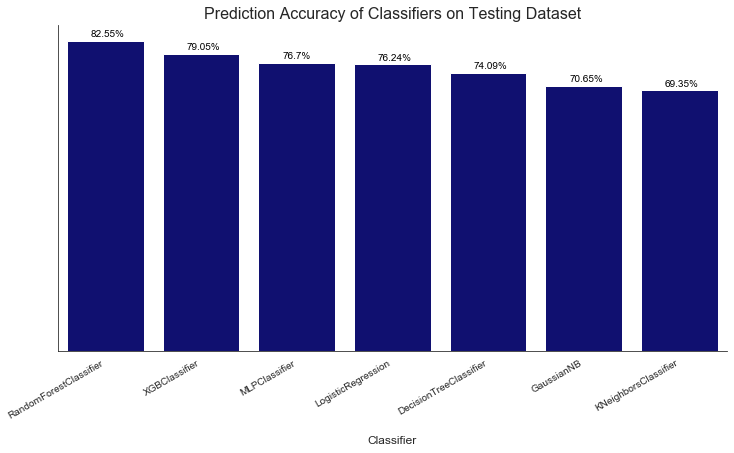

In [68]:
# let's visualize the accuracy comparison for each classifier

import seaborn as sns
sns.set_style('white')

names = [x[0] for x in preds]
acc = [float(x[2]) for x in preds]

print()
plt.figure(figsize = (12,6))
sns.barplot(names, acc, color = 'navy')
plt.xticks(rotation = 30, horizontalalignment="right")
plt.xlabel('\nClassifier', fontsize = 12)
plt.title('Prediction Accuracy of Classifiers on Testing Dataset', fontsize = 16)
plt.gca().axes.get_yaxis().set_visible(False)
sns.despine()
for i, v in enumerate(acc):
    plt.text(i - .15,v + .01, str(round(v * 100,2))+'%', color='black')

plt.show()

And now for the Confusion Matrix to see whether our errors are false positives (incorrectly predicting a first down) and a false negative (incorrectly predicting NOT getting a first down)

RandomForestClassifier Accuracy: 0.825528811086798



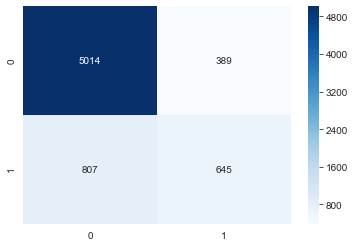

XGBClassifier Accuracy: 0.7905178701677608



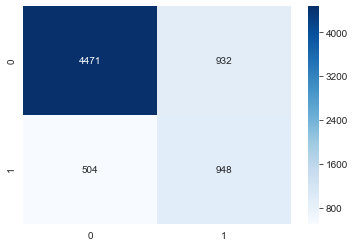

MLPClassifier Accuracy: 0.7670313639679066



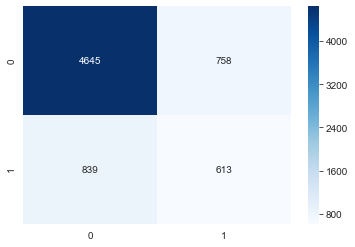

LogisticRegression Accuracy: 0.762363238512035



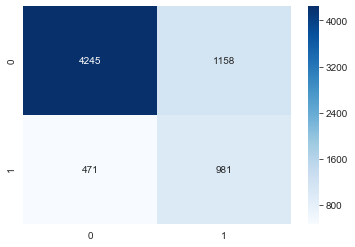

DecisionTreeClassifier Accuracy: 0.7409190371991248



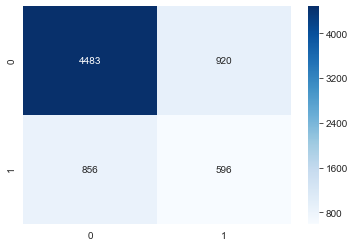

GaussianNB Accuracy: 0.7064916119620714



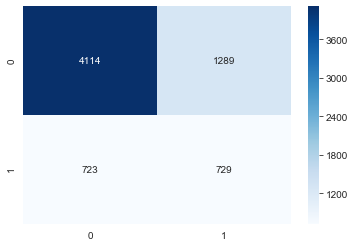

KNeighborsClassifier Accuracy: 0.6935083880379285



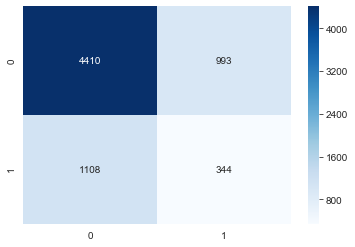

In [69]:
from sklearn import metrics
for pred in preds:
    print(pred[0] + ' Accuracy: ' + str(pred[2]), end = '\n\n')
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred[-1]))
    sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues')
    plt.show()

And now for the AUC calculations

In [70]:
for pred in preds:
    print(pred[0], end = '\n')
    print('AUC: ' + str(metrics.roc_auc_score(y_test, pred[-1])), end = '\n\n')

RandomForestClassifier
AUC: 0.686108918675422

XGBClassifier
AUC: 0.7401979004624

MLPClassifier
AUC: 0.6409419392042683

LogisticRegression
AUC: 0.7306472299594807

DecisionTreeClassifier
AUC: 0.6200962734201844

GaussianNB
AUC: 0.6317474757672122

KNeighborsClassifier
AUC: 0.526563907715793



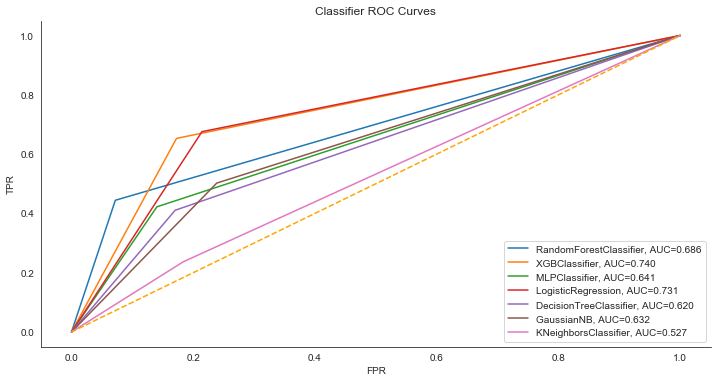

In [71]:
# Now let's plot the ROC curve to visualize the AUC values
result_table = pd.DataFrame(columns=['classifier', 'fpr','tpr','auc'])

plt.figure(figsize = (12,6))
for pred in preds:
    fpr, tpr, _ = metrics.roc_curve(y_test,  pred[-1])
    auc = metrics.roc_auc_score(y_test, pred[-1])
    result_table = result_table.append({'classifier':pred[0], 
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}, ignore_index = True)
result_table.set_index('classifier', inplace=True)

for i in result_table.index:
    sns.lineplot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.legend()
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.title('Classifier ROC Curves')
plt.ylabel('TPR')
plt.xlabel('FPR')
sns.despine()
plt.show()

So even though the Random Forest model had the highest prediction accuracy, the Gradient Boosting Machine and Logistic Regression models have higher AUC values, meaning that Logistic Regression could potentially be considered along with our RF and XGB models when making predictions.


Now let's look at what features stand out as more important across these 'top 3' different classifiers

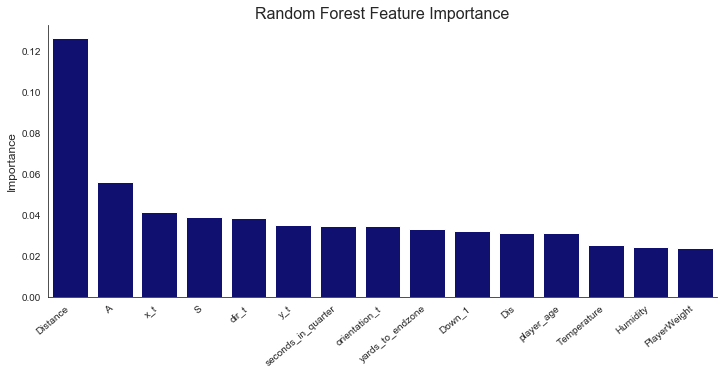

In [72]:
# random forest feature importances
importances = preds[preds[0]=='RandomForest'][1].feature_importances_
a = pd.DataFrame(importances, 
             index = X.columns)
a = a.sort_values([0], ascending = False).head(15)
plt.figure(figsize = (12,5))
sns.barplot(a.index, a[0], orient = 'v', color = 'navy')
sns.despine()
plt.ylabel('Importance', fontsize = 12)
plt.title('Random Forest Feature Importance', fontsize = 16)
plt.xticks(rotation = 40, horizontalalignment = 'right')
plt.show()

So in our best performing model, the Random Forest, the most 'important' factors for predictions are the number of yards remaining for a first down, as well as many of the measures related to the location and movement of the player when the ball is handed to them, as well as the time and location of the play. This seems to make sense, so lets check the other models 

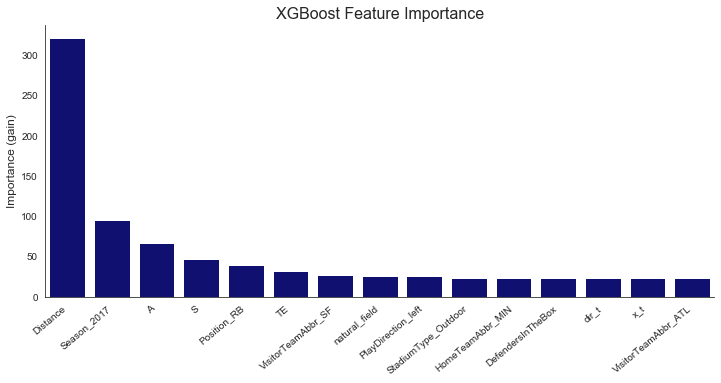

In [73]:
# feature importances for XGBoost
importances = pd.DataFrame(preds[1][1].get_booster().get_score(importance_type = 'gain').items())
importances.iloc[:,0] = importances.iloc[:,0].apply(lambda x: int(x.replace('f', ' ')))    
importances.iloc[:,0] = importances.iloc[:,0].apply(lambda i: X.columns[i])
a = importances.sort_values([1], ascending = False).head(15)
plt.figure(figsize = (12,5))
sns.barplot(a[0], a[1], orient = 'v', color = 'navy')
sns.despine()
plt.ylabel('Importance (gain)', fontsize = 12)
plt.xlabel('')
plt.title('XGBoost Feature Importance', fontsize = 16)
plt.xticks(rotation = 40, horizontalalignment = 'right')
plt.show()

So distance is again the most important feature, but interestingly the specific season that the game was played in is also important. Depending on how the classifier split the data on this variable, it could mean that there is a significant difference year-over-year in terms of running success (which is what we would imagine if the sport is developing a greater focus on passing as the years progress). Let's see if we can find out the sign of each feature using the logistic regression model

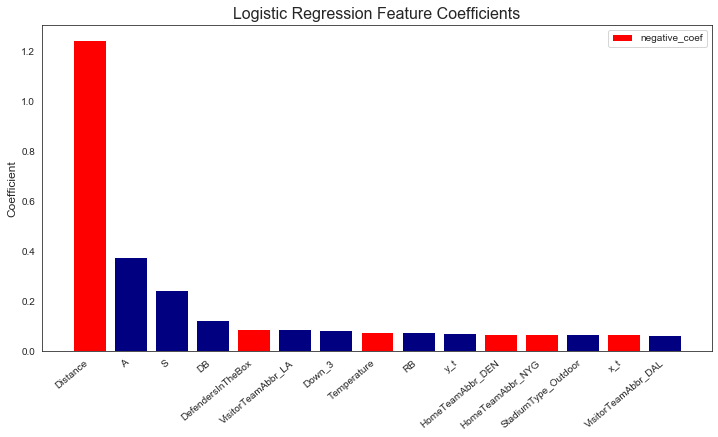

In [74]:
# logistic regression coefficients
a = pd.DataFrame(preds[3][1].coef_.T, index = X.columns, columns = ['coef'])
a = a.iloc[a.coef.abs().argsort()][::-1] # sort based on magnitude
a['sign'] = np.where(a.coef < 0, 'negative_coef', 'positive_coef')
a['coef'] = a.coef.apply(abs)
a = a.head(15)
a['color'] = np.where(a.sign == 'negative_coef', 'red', 'navy')

plt.figure(figsize = (12,6))
plt.bar(a.index, a.coef, color = a.color)
plt.xticks(rotation = 40, horizontalalignment = 'right')
plt.legend(a.sign)
plt.title('Logistic Regression Feature Coefficients', fontsize = 16)
plt.ylabel('Coefficient', fontsize = 12)
plt.show()

So distance is inversly related to the likelihood of gaining a first down, which makes sense (whew!) since the farther you have to go for a first down (larger value) the less likely you would be to gain a first down (smaller value), hense the inverse relationship. 

Additionally, it is interesting that the DB value is positive and the fourth-most influencing feature (by coefficient size). Since DBs tend to play further away from the line of scrimmage, it makes sense that a higher number of DBs on defense would lead to a higher likelihood of a first down, as there are fewer defenders near the ball.

The fact that the Down_3 coefficient is positive is a good sign as well. As the team has already had two tries to advance the ball, it is likely that on the third try they would already be closer to achieving the first down. 

Doing a sanity-check on these variables seems to indicate that our model (appears to somewhat) logically makes sense.

### Conclusion

In conclusion, we were able to build a model Random Forest modelthat could correctly predict whether or not a team would gain a first down __~82.5%__ of the time, which is higher than the majority class value (~78.85%). Additionally, our Gradient Boosting classifier also outperformed the unbalanced majority class label (albeit by a much slimmer margin).

The fact that some classifiers were performing so much better during the model training than when predictions on testing data likely means that our models were overfitting - and could due with some additional hyperparameter tuning. However, we appear to have validated the idea that when it comes to classification, the Random Forest and XGBoost classifiers are currently the head of the pack.

These models could due to be improved, potentially by additional feature engineering or potentially by incorporating more data about the other players on the field. However, for the time being we seem to have a few well-performing models. So go cheer on your favorite team knowing that running is not a forgotten part of the game.